In [ ]:
import csv

# Original- und Zielpfade
csv_path = "../data/main_dataset.csv"  # Eingabedatei
output_file = "../data/main_final_dataset.csv"  # Endgültige Ausgabedatei

# Öffne die Eingabedatei und führe beide Bereinigungen nacheinander durch
with open(csv_path, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8', newline='') as outfile:
    for line in infile:
        # Schritt 1: Entferne `;;;` am Ende der Zeile (falls vorhanden)
        cleaned_line = line.rstrip()  # Entferne Leerzeichen oder Steuerzeichen
        if cleaned_line.endswith(';;;'):
            cleaned_line = cleaned_line[:-3]  # Entferne die letzten drei Zeichen
        
        # Schritt 2: Entferne äußere Anführungszeichen (nur am Anfang und Ende der Zeile)
        if cleaned_line.startswith('"') and cleaned_line.endswith('"'):
            cleaned_line = cleaned_line[1:-1]  # Entferne das erste und letzte Zeichen

        # Schritt 3: Ersetze doppelte Anführungszeichen ("") durch einfache Anführungszeichen (")
        cleaned_line = cleaned_line.replace('""', '"')

        # Schreibe die bereinigte Zeile in die Zieldatei
        outfile.write(cleaned_line + "\n")

print(f"Die Datei wurde komplett verarbeitet und unter {output_file} gespeichert.")

Process ID (PID) of Jupyter Kernel: 41992
JOIN Information:
- Zeilen vor Join: 100
- Zeilen nach Join: 100

+----------------+
|major_percentage|
+----------------+
|            65.0|
+----------------+

Korrelation zwischen Energy und Loudness Max: 0.5608524753416658
Korrelation zwischen Loudness Max und Danceability: 0.1941958037105293
Korrelation zwischen Energy und Danceability: 0.1489083455487557


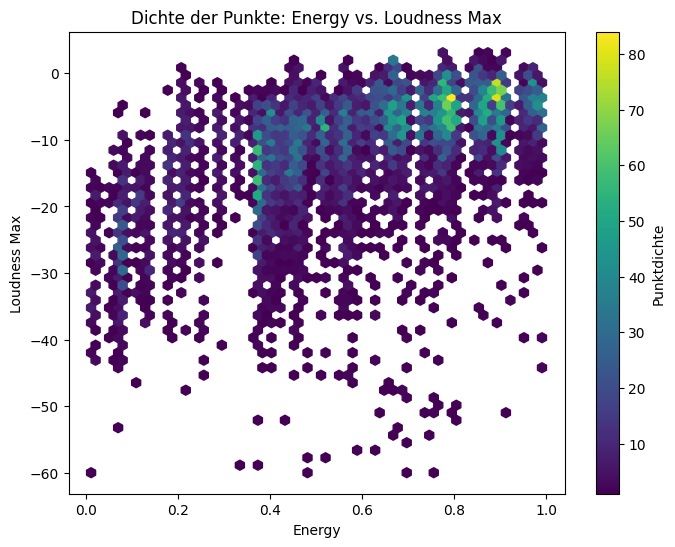

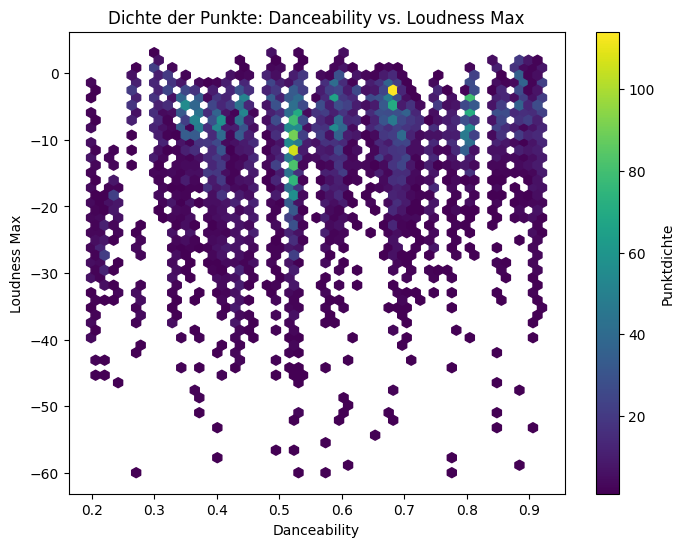

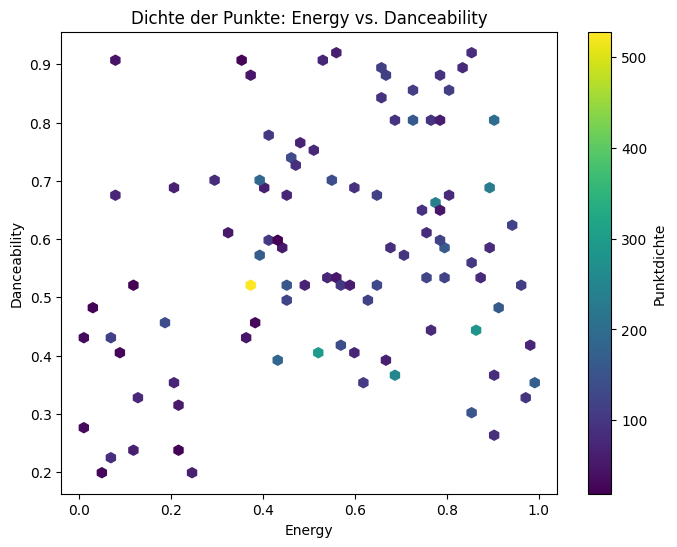

spark://localhost:7077
Codeausführung abgeschlossen. Dauer: 0.80 Minuten


In [5]:
import os
import time
import pickle
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, MapType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, size, when, round # für Schritt 5
from pyspark.sql.functions import regexp_extract # für Filtern der korrekten Track uri

# Startzeit messen
start_time = time.time()

spark = SparkSession.builder.appName("PickleToDataFramewithRDD").master("local[8]").getOrCreate()

# Verzeichnis mit den Pickle-Dateien
pickle_dir = "../data/100 Spotify Dataset"
# CSV-Datei in Spark laden
csv_path = "../data/main_final_dataset.csv"

schema = StructType([
    StructField("meta", MapType(StringType(), StringType()), True),
    StructField("track", StructType([
        StructField("num_samples", IntegerType(), True),
        StructField("duration", FloatType(), True),
        StructField("loudness", FloatType(), True),
        StructField("tempo", FloatType(), True),
        StructField("tempo_confidence", FloatType(), True),
        StructField("key", IntegerType(), True),
        StructField("key_confidence", FloatType(), True),
        StructField("mode", IntegerType(), True),
        StructField("mode_confidence", FloatType(), True),
        StructField("time_signature", IntegerType(), True),
        StructField("time_signature_confidence", FloatType(), True),
    ]), True),
    StructField("bars", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("beats", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("sections", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
        StructField("tempo", FloatType(), True),
        StructField("tempo_confidence", FloatType(), True),
        StructField("key", IntegerType(), True),
        StructField("key_confidence", FloatType(), True),
        StructField("mode", IntegerType(), True),
        StructField("mode_confidence", FloatType(), True),
        StructField("time_signature", IntegerType(), True),
        StructField("time_signature_confidence", FloatType(), True),
    ])), True),
    StructField("segments", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
        StructField("loudness_start", FloatType(), True),
        StructField("loudness_max", FloatType(), True),
        StructField("loudness_max_time", FloatType(), True),
        StructField("pitches", ArrayType(FloatType()), True),
        StructField("timbre", ArrayType(FloatType()), True),
    ])), True),
    StructField("tatums", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("track_uri", StringType(), True),
])


# CSV File einlesen: quote berücksichtigt das Inhalte zwischen " " als eine Spalte genommen werden
csv_df = spark.read.option("header", True).option("quote", '"').option("inferSchema", True).csv(csv_path)
# Alle Pickle-Dateien sammeln
pickle_files = [os.path.join(pickle_dir, f) for f in os.listdir(pickle_dir) if f.endswith(".pkl") or f.endswith(".pickle")]

# RDD erstellen basierend auf der Liste der Pickle-Dateien
pickle_rdd = spark.sparkContext.parallelize(pickle_files)

def process_pickle(filepath):
    try:
        with open(filepath, "rb") as file:
            pickle_data = pickle.load(file)

        return {
            "track_uri": pickle_data.get("track_uri", "Unbekannt"),
            "bars": pickle_data.get("bars", []),
            "duration_ms": pickle_data.get("duration_ms", "Unbekannt"),
            "sections": pickle_data.get("sections", []),
            "segments": pickle_data.get("segments", []),
            "loudness_max": pickle_data.get("loudness_max", "Unbekannt"),
            "keys": pickle_data.get("keys", []),
            "track": pickle_data.get("track", [])
        }
    except Exception as e:
        return {"track_uri": None, "error": str(e)}

# Pickle-Dateien parallel verarbeiten
processed_rdd = pickle_rdd.map(process_pickle)

# RDD in Spark DataFrame umwandeln
pickle_df = spark.createDataFrame(processed_rdd, schema=schema)

# Fehlerhafte Einträge herausfiltern
valid_pickle_df = pickle_df.filter(pickle_df.track_uri.isNotNull())

# CSV-Daten mit Pickle-Daten verbinden
combined_df = valid_pickle_df.join(csv_df, valid_pickle_df["track_uri"] == csv_df["track_uri_csv"], how="inner")

# Join-Information fürs Debugging
print(f"JOIN Information:")
print(f"- Zeilen vor Join: {valid_pickle_df.count()}")
print(f"- Zeilen nach Join: {combined_df.count()}")
print("")

# Statistik anzeigen
total_files = len(pickle_files)
successful_files = valid_pickle_df.count()
failed_files = total_files - successful_files

print(f"Statistik:")
print(f"- Gesamtanzahl der Dateien: {total_files}")
print(f"- Erfolgreich verarbeitet: {successful_files}")
print(f"- Fehlerhaft: {failed_files}")

# 1. Berechnung des Durchschnittsmodus und Major-Prozentsatz für alle Songs
# Erstelle eine neue Spalte, die 1 ist, wenn der Modus 'Major' (1) ist, sonst 0
combined_df = combined_df.withColumn("is_major", F.when(combined_df["mode"] == 1, 1).otherwise(0))

# Gruppiere nach einer geeigneten Ebene (falls erforderlich, z.B. über alle Daten)
mode_stats = combined_df.agg(round(F.mean("is_major")*100,2).alias("major_percentage"))

# Ergebnisse anzeigen
mode_stats.show()

# Schritt 1: Sicherstellen, dass die Spalten den Typ "double" haben
combined_df = combined_df.withColumn("energy", combined_df["energy"].cast("double")).withColumn("danceability", combined_df["danceability"].cast("double"))

# Schritt 2: Explodieren der "segments"-Spalte und Extrahieren von "loudness_max"
# Hier Zugriff auf Information der Pickle Datei: Da diese eine geschachtelte Struktur enthält, muss zunächst auf Segments zugegriffen werden und anschließend auf loudness max
exploded_df = combined_df.withColumn("segment", F.explode("segments")).withColumn("loudness_max_segment", F.col("segment.loudness_max").cast("double"))

# Schritt 3: Filtern der Zeilen, um null-Werte zu vermeiden und Berechnung der Korrelationen
filtered_df = exploded_df.filter((F.col("energy").isNotNull()) & (F.col("danceability").isNotNull()) & (F.col("loudness_max_segment").isNotNull()))

# Berechnung der Korrelationen
correlation_energy_loudness_max = filtered_df.stat.corr("energy", "loudness_max_segment")
correlation_loudness_max_danceability = filtered_df.stat.corr("loudness_max_segment", "danceability")
correlation_energy_danceability = filtered_df.stat.corr("energy", "danceability")

# Ausgabe der Korrelationen
print(f"Korrelation zwischen Energy und Loudness Max: {correlation_energy_loudness_max}")
print(f"Korrelation zwischen Loudness Max und Danceability: {correlation_loudness_max_danceability}")
print(f"Korrelation zwischen Energy und Danceability: {correlation_energy_danceability}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from pyspark.sql.functions import col

# Spark DataFrame vorbereiten
filtered_df = filtered_df.select(
    col("energy").cast("float"),
    col("loudness_max_segment").cast("float"),
    col("danceability").cast("float")
).na.drop()

# Sampling der Daten (10.000 Zeilen für Visualisierung)
sample_size = 10000
sampled_df = filtered_df.sample(fraction=sample_size / filtered_df.count())

# Umwandeln der Stichprobe in Pandas DataFrame
filtered_pd_df = sampled_df.toPandas()

# Visualisierung 1: Hexbin-Dichteplot für Energy vs. Loudness Max
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["energy"], filtered_pd_df["loudness_max_segment"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Energy vs. Loudness Max")
plt.xlabel("Energy")
plt.ylabel("Loudness Max")
plt.show()

# Visualisierung 2: Hexbin-Dichteplot für Danceability vs. Loudness Max
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["danceability"], filtered_pd_df["loudness_max_segment"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Danceability vs. Loudness Max")
plt.xlabel("Danceability")
plt.ylabel("Loudness Max")
plt.show()


#Visualisierung 3: Energy vs. Danceability
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["energy"], filtered_pd_df["danceability"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Energy vs. Danceability")
plt.xlabel("Energy")
plt.ylabel("Danceability")
plt.show()

print(spark.conf.get("spark.master"))  # Sollte "local[2]" ausgeben

# Endzeit messen
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Codeausführung abgeschlossen. Dauer: {execution_time_minutes:.2f} Minuten")